# TikTok Echo Chamber Model

## Background

The TikTok Echo Chamber model seeks to simulate the creation and sustenance of echo chambers on TikTok via bot to bot interactions. It utilizes agent-based modelling to demonstrate how agents - human or bot - of varying political leanings - conservative, progressive or neutral - interact with one another and take-on/lose each other's political leanings, eventually finding themselves surrounded by agents with similar leanings.

The model categorizes interactions like following, sharing, commenting and liking as positive interactions since they promote connection and increase the likelihood of political leanings being adopted. Conversely, interactions like unfollowing and disliking are thus categorized as negative interactions.

Agents are randomly placed on a graph. Human agents start off neutral to reflect a non-tailored For You Page (FYP) when a new user joins TikTok. There is at least one bot agent in the network and bot agents, as in real life, start off with a non-neutral political leaning with the goal of spreading that leaning. Human agents are able to have positive or negative interactions with other agents, while bot agents can only have positive interactions since they aim to spread their leanings. Upon a positive interaction, an agent tries to pass on its leaning to another. Upon a negative interaction, the receiving agent will try to change its political leaning to something other than the initiating agent's.

While individual human agents may interact with others of dissimilar leanings, the amplification of some leaning by bots near the human agent nonetheless leads to clusters of similar leanings.

## Implementation

This is a demonstration of running the TikTok Echo Chamber model in an IPython Notebook. The actual model and agent code are implemented in the src directory of this Github repo. Below, we will import the model class, instantiate it, run it, and plot the time series of the number of happy agents.

Please note that you may have to edit the source code since imports may not be identified in different settings. If the below import fails, make the following changes

In src/app.py change:
<code>from agents import</code> to <code>from src.agents import</code>
<code>from model import</code> to <code>from src.model import</code>

In src/model.py change:
<code>from agents import</code> to <code>from src.agents import</code>

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from src.model import TikTokEchoChamber

Now we instantiate a model instance: 10 nodes with 1-2 bot nodes and an average node degree of 3. The likelihood of agents to have a positive interaction with others is 40%, with a 30% chance to pass on their leaning. After a negative interaction, they have a 50% chance to become neutral.

In [21]:
ttec_model = TikTokEchoChamber(
    num_nodes=10,
    avg_node_degree=3,
    num_bots=1,
    positive_chance=0.4,
    politics_change_chance=0.3,
    become_neutral_chance=0.5,
    seed=42
)

/Users/greatlovebariboloka/IdeaProjects/eecs4461-project/src/venv/lib/python3.12/site-packages/mesa/space.py:1549: UserWarning: Random number generator not specified, this can make models non-reproducible. Please pass a random number generator explicitly
  return AgentSet(agents, random=rng)


The model will run until all agents are of non-neutral leaning. However, there's no guarantee that a given model instantiation will *ever* settle down. So it will run for either 100 steps or until it stops on its own, whichever comes first:

In [22]:
while ttec_model.running and ttec_model.steps < 100:
    ttec_model.step()
print(f"Number of Steps {ttec_model.steps}")  # Show how many steps have actually run

Number of Steps 9


Generate a pandas DataFrame of the number of conservative, progressive and neutral agent at the end of each step.

In [23]:
model_out = ttec_model.datacollector.get_model_vars_dataframe()

In [24]:
model_out.head()

,Conservative,Progressive,Neutral,Num_Cluster,Avg_Cluster
0,1,1,8,3,3.333333
1,5,2,3,3,3.333333
2,1,3,6,3,3.333333
3,1,5,4,3,3.333333
4,2,3,5,3,3.333333


Finally, plot the series of political leanings:

<Axes: >

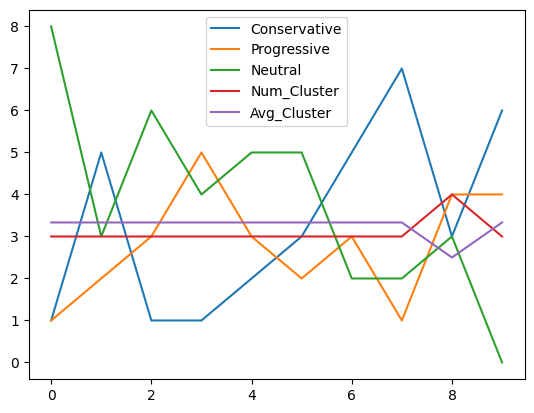

In [25]:
model_out.plot()

# Effect of Number of Bots on Number of Clusters

Below we do a parameter sweep to see how the number of clusters changes with the number of bots.

First, we create a function which takes a model instance and returns the number of clusters ie. agents in  proximity to one another which also have similar leanings.

In [26]:
from mesa.batchrunner import batch_run

Now, we set up the batch run, with a dictionary of fixed and changing parameters. Let's hold everything fixed except for Number of Bots. Please note that the model tries to instantiate one bot of each typenumber of bots indicates

In [27]:
fixed_params = {"num_nodes": 20, "avg_node_degree": 3, "positive_chance": 0.5,
                "politics_change_chance": 0.3, "become_neutral_chance": 0.5}
variable_params = {"num_bots": range(1, 9)}
all_params = fixed_params | variable_params

In [28]:
results = batch_run(
    TikTokEchoChamber,
    parameters=all_params,
    iterations=10,
    max_steps=200,
)

  0%|          | 0/80 [00:00<?, ?it/s]

/Users/greatlovebariboloka/IdeaProjects/eecs4461-project/src/venv/lib/python3.12/site-packages/mesa/space.py:1549: UserWarning: Random number generator not specified, this can make models non-reproducible. Please pass a random number generator explicitly
  return AgentSet(agents, random=rng)


In [29]:
df = pd.DataFrame(results)
df

,RunId,iteration,Step,num_nodes,avg_node_degree,positive_chance,politics_change_chance,become_neutral_chance,num_bots,Conservative,Progressive,Neutral,Num_Cluster,Avg_Cluster
0,0,0,156,20,3,0.5,0.3,0.5,1,16,3,1,3,6.666667
1,1,0,49,20,3,0.5,0.3,0.5,2,14,4,2,4,5.000000
2,2,0,3,20,3,0.5,0.3,0.5,3,4,14,2,6,3.333333
3,3,0,2,20,3,0.5,0.3,0.5,4,14,5,1,5,4.000000
4,4,0,4,20,3,0.5,0.3,0.5,5,5,13,2,6,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,9,6,20,3,0.5,0.3,0.5,4,9,10,1,4,5.000000
76,76,9,5,20,3,0.5,0.3,0.5,5,8,11,1,5,4.000000
77,77,9,1,20,3,0.5,0.3,0.5,6,10,8,2,4,5.000000
78,78,9,1,20,3,0.5,0.3,0.5,7,10,9,1,3,6.666667


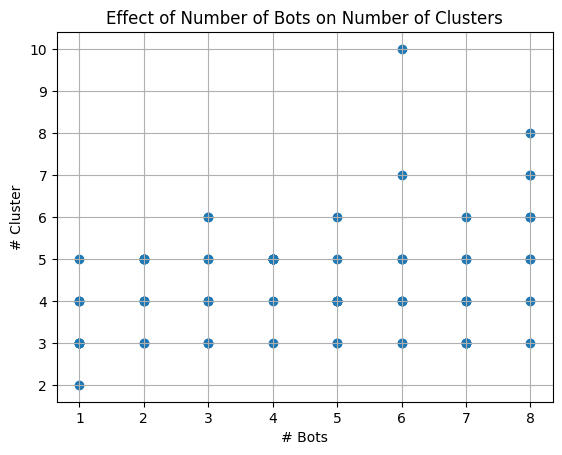

In [30]:
plt.scatter(df.num_bots, df.Num_Cluster)
plt.xlabel("# Bots")
plt.ylabel("# Cluster")
plt.grid()
plt.title("Effect of Number of Bots on Number of Clusters")
plt.show()

# Effect of Probability to Follow on Average Cluster Size

How big do clusters get when agents are more likely to connect than disconnect?

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/greatlovebariboloka/IdeaProjects/eecs4461-project/src/venv/lib/python3.12/site-packages/mesa/space.py:1549: UserWarning: Random number generator not specified, this can make models non-reproducible. Please pass a random number generator explicitly
  return AgentSet(agents, random=rng)


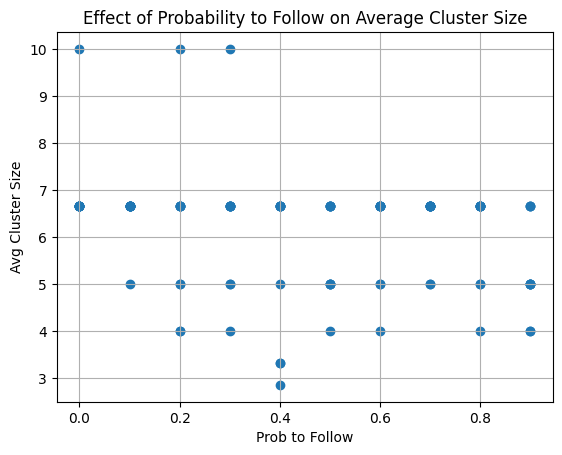

In [31]:
from numpy import arange

fixed_params2 = {"num_nodes": 20, "avg_node_degree": 3, "num_bots": 1,
                "politics_change_chance": 0.3, "become_neutral_chance": 0.5}
variable_params2 = {"positive_chance": arange(0.0, 1.0, 0.1)}
all_params2 = fixed_params2 | variable_params2

results2 = batch_run(
    TikTokEchoChamber,
    parameters=all_params2,
    iterations=10,
    max_steps=200,
)

df2 = pd.DataFrame(results2)
df2

plt.scatter(df2.positive_chance, df2.Avg_Cluster)
plt.xlabel("Prob to Follow")
plt.ylabel("Avg Cluster Size")
plt.grid()
plt.title("Effect of Probability to Follow on Average Cluster Size")
plt.show()

# Effect of Bot Political Leaning Distribution on Final Political Leaning Distribution

When there is a majority of conservative bots, how does that affect the final political leanings of the network? Likewise progressive bots?

  0%|          | 0/70 [00:00<?, ?it/s]

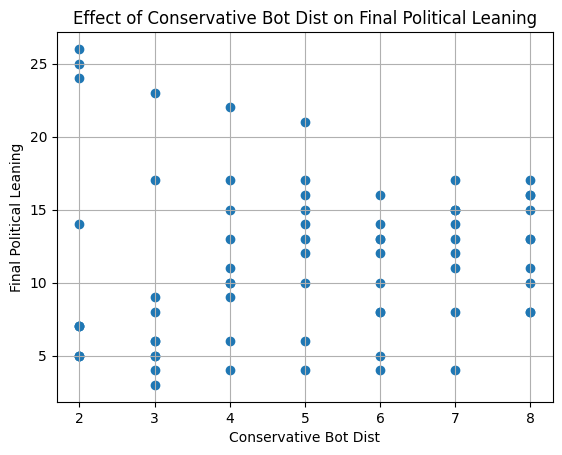

In [32]:
fixed_params3 = {"num_nodes": 30, "avg_node_degree": 3, "positive_chance": 0.5,
                 "politics_change_chance": 0.3, "become_neutral_chance": 0.5}
variable_params3 = {"num_bots": range(2,9)}
all_params3 = fixed_params3 | variable_params3

results3 = batch_run(
    TikTokEchoChamber,
    parameters=all_params3,
    iterations=10,
    max_steps=200,
)
df3 = pd.DataFrame(results3)
df3

plt.scatter(df3.num_bots, df3.Conservative)
plt.xlabel("Conservative Bot Dist")
plt.ylabel("Final Political Leaning")
plt.grid()
plt.title("Effect of Conservative Bot Dist on Final Political Leaning")
plt.show()

## References

This document was adopted from the Mesa Schelling model analysis file found at the mesa examples repository on GitHub
    [https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling](https://github.com/projectmesa/mesa/tree/main/mesa/examples/basic/schelling)